In [2]:
from pathlib import Path
import pandas as pd
from bitis.texture.properties import (
    PatternPropertiesBuilder,
)

import numpy as np
from skimage import io


class ImageParser:
    def __init__(self):
        pass

    @staticmethod
    def read_png(path):
        image = io.imread(path, as_gray=True)
        return np.add(image < 0.4, image < 0.8, dtype=int)

    @staticmethod
    def write_png(image, path):
        fib = [153, 1, 2]
        myo = [226, 168, 88]

        out_image = np.zeros((image.shape[0], image.shape[1], 3),
                             dtype=np.uint8)
        out_image[image == 1] = myo
        out_image[image == 2] = fib
        io.imsave(path, out_image)


def calc_props(image, area_min=10, area_quantile=0.95):
    pattern_builder = PatternPropertiesBuilder(area_quantile=area_quantile,
                                               area_min=area_min)
    pattern_props = pattern_builder.build(image == 2)
    return pattern_props, pattern_builder.object_props


def read_image(path):
    image = ImageParser.read_png(path)
    image[image == 0] = 1
    return image[:100, :100]


def make_pattern_stats(path, pattern_ids, n_samples=100):
    
    all_pattern_props = []
    all_object_props = []
    for pattern_id in pattern_ids:
        for i in range(n_samples):
            image = read_image(path.joinpath(f'simulated_{pattern_id}',
                                             f'gen_tex_{pattern_id}_{i}.png'))
            
            pattern_props, object_props = calc_props(image)
            pattern_props['pattern_id'] = pattern_id

            object_props['pattern_id'] = pattern_id
            object_props['sample_id'] = i

            all_pattern_props.append(pattern_props)
            all_object_props.append(object_props)
    
    all_pattern_props = pd.concat(all_pattern_props).reset_index(drop=True)
    all_object_props = pd.concat(all_object_props).reset_index(drop=True)
    return all_pattern_props, all_object_props

In [3]:
path = Path('/home/arstan/Projects/Fibrosis/BiTis/data')

pattern_ids = [25, 2, 34, 5]
_, data = make_pattern_stats(path, pattern_ids)
data['orientation'] = np.degrees(data['orientation'])

### Load Training and Uniform Generator data

In [38]:
from tqdm import tqdm

uni_data = []
tr_data = []

for pattern_id in pattern_ids:
    tr_image = read_image(path.joinpath('training',
                                        f'or_tex_{pattern_id}.png'))
    _, oprops = calc_props(tr_image)
    oprops['pattern_id'] = pattern_id
    oprops['sample_id'] = 0
    tr_data.append(oprops)

for pattern_id in pattern_ids:
    tr_image = read_image(path.joinpath('training',
                                        f'or_tex_{pattern_id}.png'))
    dens = np.mean(tr_image == 2)
    
    for i in tqdm(range(100)):
        # Generate uniform image
        uni_image = 1 + (np.random.random(tr_image.shape) <= dens).astype(int)
        try:
            _, oprops = calc_props(uni_image)
        except UserWarning:
            pass

        oprops['pattern_id'] = pattern_id
        oprops['sample_id'] = i

        uni_data.append(oprops)


tr_data = pd.concat(tr_data).reset_index(drop=True)
tr_data['orientation'] = np.degrees(tr_data['orientation'])

uni_data = pd.concat(uni_data).reset_index(drop=True)
uni_data['orientation'] = np.degrees(uni_data['orientation'])

  3%|▎         | 3/100 [00:01<00:48,  2.00it/s]/home/arstan/Projects/Fibrosis/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
 17%|█▋        | 17/100 [00:08<00:43,  1.92it/s]/home/arstan/Projects/Fibrosis/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
 50%|█████     | 50/100 [00:25<00:25,  1.97it/s]/home/arstan/Projects/Fibrosis/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
 67%|██████▋   | 67/100 [00:33<00:16,  1.95it/s]/home/arstan/Projects/Fibrosis/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to b

In [5]:
def correct_orientation(data, p_id, base_orient):
    mask = (data['pattern_id'] == p_id) & (data['orientation'] > base_orient + 90)
    data.loc[mask , 'orientation'] = data.loc[mask, 'orientation'] - 180
    mask = (data['pattern_id'] == p_id) & (data['orientation'] < base_orient - 90)
    data.loc[mask , 'orientation'] = data.loc[mask, 'orientation'] + 180
    return data

In [39]:
data_all = []

data['source'] = 'ds'
tr_data['source'] = 'tr'
uni_data['source'] = 'uni'

data_all = pd.concat([data, tr_data, uni_data]).reset_index(drop=True)
data_all['source'] = data_all['source'].astype('category')
data_all = data_all[data_all['area'] > 10]

for p_id, base_orient in zip([25, 2, 34, 5], [-28, 76, -49, 50]):
    data_all = correct_orientation(data_all, p_id, base_orient)

columns = ['source', 'pattern_id', 'axis_ratio', 'orientation',
           'solidity']
res = data_all[columns].groupby(['source', 'pattern_id']).describe().T
res.sort_index(axis=1, level=1, inplace=True)

/tmp/ipykernel_10519/2745637995.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = data_all[columns].groupby(['source', 'pattern_id']).describe().T


In [40]:
r = res.loc['orientation', '25%'].round(1).reset_index()
r['pattern_id'] = r['pattern_id'].map({v: k+1 for k, v in enumerate(pattern_ids)})
r

,source,pattern_id,orientation
,,,25%
0,ds,2,69.7
1,tr,2,68.7
2,uni,2,32.9
3,ds,4,20.0
4,tr,4,37.7
5,uni,4,4.6
6,ds,1,-33.5
7,tr,1,-31.6
8,uni,1,-75.1


In [41]:
def calc_ccdf(df):
    count = np.bincount(df['area'].to_numpy(dtype=int))
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


def calc_area_cdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


def draw_area_cdf(ax, objects_props, label='', color='blue', alpha=1.0):
    area_bins, cdf = calc_area_cdf(objects_props)
    ax.plot(area_bins, cdf, label=label, color=color, alpha=alpha)
    ax.set_xlabel('Cluster Size', fontsize=16)
    ax.set_ylabel('Fibrotic Tissue', fontsize=16)
    ax.set_xscale('log')


def draw_ccdf(ax, objects_props, label='', color='blue', alpha=1.0):
    area_bins, ccdf = calc_ccdf(objects_props)
    ax.plot(area_bins, ccdf, label=label, color=color, alpha=alpha)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which='both', alpha=0.5)

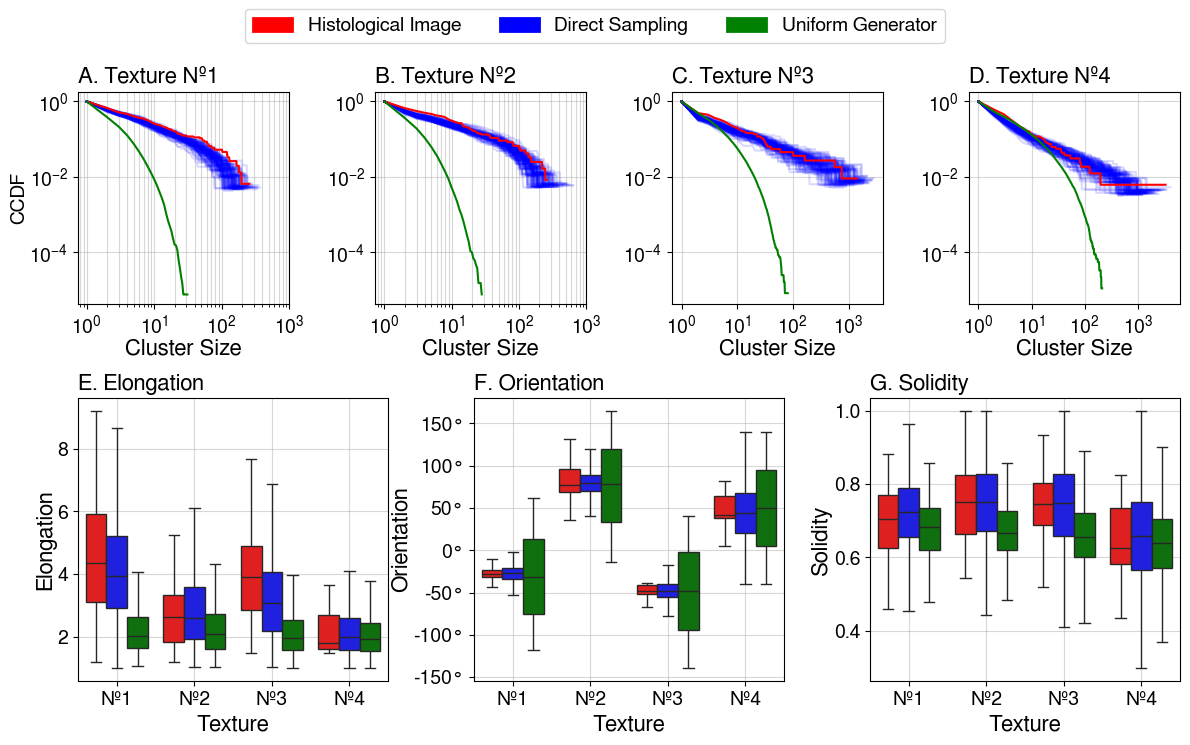

In [42]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rc('font', family='FreeSans')


fig, axs = plt.subplot_mosaic([['a'] * 3 + ['b'] * 3 + ['c'] * 3 + ['d'] * 3,
                               ['e'] * 4 + ['f'] * 4 + ['g'] * 4],
                                figsize=(12, 7.5),
                                height_ratios=[3, 4])

# Draw area CCDF
for i, (pattern_id, subplot) in enumerate(zip(pattern_ids,
                                              ['a', 'b', 'c', 'd'])):
    ax = axs[subplot]
    for j in range(100):
        mask = ((data['pattern_id'] == pattern_id)
                & (data['sample_id'] == j))
        draw_ccdf(ax, data[mask], color='blue', alpha=0.15)

    draw_ccdf(ax, tr_data[tr_data['pattern_id'] == pattern_id],
              label='Histological Image', color='red', alpha=1.0)
    draw_ccdf(ax, uni_data[uni_data['pattern_id'] == pattern_id],
              label='Uniform Generator', color='g', alpha=1.0)


for subplot, prop_name in zip(['e', 'f', 'g'],
                              ['axis_ratio', 'orientation', 'solidity']):
    ax = axs[subplot]
    sns.boxplot(x='pattern_id', y=prop_name, data=data_all,
                order=pattern_ids, ax=ax, linewidth=1, hue='source',
                hue_order=['tr', 'ds', 'uni'],
                palette=['red', 'blue', 'green'], legend=False,
                showfliers=False)

#
for i, subplot in enumerate(['a', 'b', 'c', 'd']):
    ax = axs[subplot]
    ax.set_xlabel('Cluster Size', fontsize=16, labelpad=1)
    ax.set_title(f'{subplot.upper()}. Texture Nº{i+1}', fontsize=16,
                 loc='left')
    ax.set_xticks([1, 10, 100, 1000,])
    ax.grid(True, which='both', alpha=0.5)
    ax.sharey(axs['a'])

axs['a'].set_ylabel('CCDF', fontsize=14, labelpad=1)

for subplot, title in zip(['e', 'f', 'g'],
                          ['Elongation', 'Orientation', 'Solidity']):
    ax = axs[subplot]
    ax.set_xticks(np.arange(len(pattern_ids)))
    ax.set_xticklabels([f'Nº{i}' for i in range(1, 1 + len(pattern_ids))],
                           fontsize=14)
    ax.set_xlabel('Texture', fontsize=16)
    ax.set_title(f'{subplot.upper()}. {title}', fontsize=16, loc='left')
    ax.set_ylabel(title, fontsize=16, labelpad=1)
    ax.grid(True, which='both', alpha=0.5)

# axs['f'].set_ylim(-90, 90)
# axs['f'].set_yticks(np.linspace(-90, 90, 7))
axs['f'].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{x:.0f}°'))

for k, v in axs.items():
    v.tick_params(axis='both', which='major', labelsize=14)

legend_patches = [mpatches.Patch(facecolor='red', edgecolor='red',
                                    linewidth=2, label='Histological Image'),
                    mpatches.Patch(facecolor='blue', edgecolor='blue',
                                    linewidth=2, label='Direct Sampling'),
                    mpatches.Patch(facecolor='green', edgecolor='green',
                                    linewidth=2, label='Uniform Generator')]
fig.legend(handles=legend_patches, loc='upper center', ncol=3, prop={'size': 14})
plt.tight_layout(rect=[0, 0, 1, 0.93], h_pad=1, w_pad=0.2)
plt.show()


In [12]:
path_save = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('generation_quality_clusters.png'),
            dpi=300, bbox_inches='tight')